In [ ]:
# ---------------------------
# 1. Prerequisites:
# ---------------------------
#%pip install -r requirements.txt # Installer les dépendances listées dans requirements.txt

#Connexion à Supabase S3-compatible
#Lecture du CSV df_competence_rome_eda_v2.csv
#Préparation des dictionnaires et pondérations
#Définition du modèle Transformer pour profils métiers
#Fonction make_batch avec padding
#Loss contrastive
#Entraînement avec validation, sauvegardes tous les 500 epochs et early stopping
#Sauvegarde .pkl sur S3

#graphiques

In [14]:
# ---------------------------
# 1. Importation des bibliothèques
# ---------------------------
import pandas as pd                                                  # Manipulation de données tabulaires
import torch                                                         # PyTorch pour DL
import torch.nn as nn                                                # Couches réseau
import torch.nn.functional as F                                      # Fonctions utilitaires
import random                                                        # Générateur aléatoire
import math                                                          # Fonctions mathématiques
import os                                                            # Gestion fichiers
from dotenv import load_dotenv                                       # Variables d'environnement
import boto3                                                         # Client S3
import io                                                            # Flux binaire
import tempfile                                                      # Fichiers temporaires
import joblib                                                        # Sauvegarde / chargement objets Python
import matplotlib.pyplot as plt                                      # Visualisation
import numpy as np                                                   # Manipulation de tableaux
from sklearn.metrics import f1_score                                 # F1-score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matrice de confusion
from sklearn.manifold import TSNE                                    # Réduction de dimension TSNE


print("Bibliothèques importées")

Bibliothèques importées


In [15]:
# ---------------------------
# 2. Connexion à Supabase (S3-compatible)
# ---------------------------
load_dotenv('.env')                                         # Charge les variables depuis le fichier .env

# Initialisation client S3
s3_client = boto3.client( 
    service_name='s3',                                      # Type de service : S3
    region_name=os.getenv("S3_REGION"),                     # Région où le bucket est hébergé
    endpoint_url=os.getenv("S3_ENDPOINT_URL"),              # Endpoint S3 (Supabase spécifique)
    aws_access_key_id=os.getenv("S3_ACCESS_KEY_ID"),        # Clé d'accès S3
    aws_secret_access_key=os.getenv("S3_SECRET_ACCESS_KEY") # Secret S3
)

bucket_name = "dlhybride"                                   # Nom du bucket
print("Connexion S3 initialisée")

Connexion S3 initialisée


In [16]:
# ---------------------------
# 3. Lecture CSV depuis S3
# ---------------------------
def read_ml_from_s3(s3_file_key):
    """
    Lit un fichier CSV depuis un bucket S3 et retourne un DataFrame pandas
    Arguments :
        - file_name : nom du fichier CSV dans le bucket
        - bucket_name : nom du bucket S3 (par défaut 'dlhybride')
    """
    # Récupère l'objet depuis le bucket
    try:
        obj = s3_client.get_object(Bucket=bucket_name, Key=s3_file_key)
        # Lit le contenu en mémoire et le convertit en DataFrame
        df = pd.read_csv(io.BytesIO(obj['Body'].read()), dtype=str)
        return df
    except Exception as ex:
        print("Erreur lecture CSV depuis S3:", ex)
        return None

# Lecture du CSV
df = read_ml_from_s3('df_competence_rome_eda_v2.csv')
if df is None:
    raise FileNotFoundError("Impossible de charger df_competence_rome_eda_v2.csv")

print(f"CSV chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes") # Affiche dimensions(nombre lignes et colonnes)

CSV chargé : 38961 lignes, 17 colonnes


In [17]:
# ---------------------------
# 4. Préparation des dictionnaires
# ---------------------------

# Vocabulaire des compétences : chaque compétence a un ID unique
skills_vocab = {s: i for i, s in enumerate(df['code_ogr_competence'].unique())}

# Vocabulaire des métiers : chaque code ROME a un ID unique
jobs_vocab = {j: i for i, j in enumerate(df['code_rome'].unique())}

# Dictionnaire métier → libellé métier
job_labels = df.drop_duplicates('code_rome').set_index('code_rome')['libelle_rome'].to_dict()

# Dictionnaire métier → liste des compétences associées
job_to_skills = df.groupby('code_rome')['code_ogr_competence'].apply(list).to_dict()

# Dictionnaire compétence → libellé compétence
skill_to_label = df.drop_duplicates('code_ogr_competence').set_index('code_ogr_competence')['libelle_competence'].to_dict()

# Statistiques : nombre de compétences et métiers
n_skills = len(skills_vocab)
n_jobs = len(jobs_vocab)

# Pondération des compétences (inverse de leur fréquence)
skill_freq = df['code_ogr_competence'].value_counts().to_dict()
skill_weight = {s: 1.0 / math.log(1 + f) for s, f in skill_freq.items()}

print(f"{n_skills} compétences et {n_jobs} métiers chargés depuis CSV")

16583 compétences et 1584 métiers chargés depuis CSV


In [18]:
# ---------------------------
# 5. Définition du modèle Transformer
# ---------------------------

# Définition d'une classe de modèle basée sur nn.Module (PyTorch)
class JobProfileTransformer(nn.Module):
    def __init__(self, n_skills, n_jobs, emb_dim=64, n_heads=4, n_layers=2, max_len=88):
        super().__init__()  # Initialise la classe parente nn.Module
        
        # Embedding pour représenter chaque "skill" (compétence) par un vecteur dense
        self.skill_emb = nn.Embedding(n_skills, emb_dim)
        
        # Embedding positionnel (appris) pour indiquer l'ordre des compétences dans le profil
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        
        # Définition d’un bloc de Transformer Encoder (une seule couche)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,      # dimension des embeddings
            nhead=n_heads,        # nombre de têtes d’attention
            dim_feedforward=256,  # taille de la couche feedforward interne
            batch_first=True      # format (batch, seq, dim) au lieu de (seq, batch, dim)
        )
        
        # Empile plusieurs couches d’encoder pour former le Transformer complet
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Embedding pour représenter chaque métier (job) par un vecteur dense
        self.job_emb = nn.Embedding(n_jobs, emb_dim)

    # Fonction pour encoder un profil de compétences (séquence de skills)
    def encode_profile(self, skills, weights=None):
        # Récupère les dimensions du batch et de la séquence
        batch_size, seq_len = skills.shape
        
        # Sélectionne (ou répète si nécessaire) les embeddings positionnels selon la longueur de la séquence
        pos_emb = (
            self.pos_emb[:, :seq_len, :] 
            if seq_len <= self.pos_emb.size(1) 
            else self.pos_emb.repeat(1, math.ceil(seq_len / self.pos_emb.size(1)), 1)[:, :seq_len, :]
        )
        
        # Somme des embeddings de compétences et des embeddings positionnels
        skills_emb = self.skill_emb(skills) + pos_emb
        
        # Si des poids sont fournis (importance relative des compétences), on les applique
        if weights is not None:
            skills_emb = skills_emb * weights.unsqueeze(-1)
        
        # Création du masque : True si skill == 0 (padding), False sinon
        mask = (skills == 0)
        
        # Passage des embeddings dans l’encodeur Transformer (avec le masque pour ignorer le padding)
        v = self.encoder(skills_emb, src_key_padding_mask=mask)
        
        # Retourne une représentation normalisée du profil (moyenne des tokens)
        return F.normalize(v.mean(dim=1), dim=1)

    # Fonction pour encoder directement les identifiants de métiers
    def encode_job(self, job_ids):
        # Retourne les embeddings des métiers normalisés
        return F.normalize(self.job_emb(job_ids), dim=1)


# Message de confirmation que le modèle est bien défini
print("Modèle Transformer défini")


Modèle Transformer défini


In [19]:
# ---------------------------
# 6. Loss contrastive
# ---------------------------

# Définition d'une fonction de perte "contrastive" pour l'appariement profils ↔ métiers
def contrastive_ranking_loss(v_p, v_j_pos, v_j_neg, temperature=0.1):
    # v_p      : vecteurs des profils (batch_size, dim)
    # v_j_pos  : vecteurs des jobs positifs (associés au profil) (batch_size, dim)
    # v_j_neg  : vecteurs des jobs négatifs (non associés) (batch_size, nb_neg, dim)
    # temperature : paramètre qui contrôle la "douceur" de la distribution softmax

    # Produit scalaire entre profil et job positif (similarité cosinus si vecteurs normalisés)
    # Résultat : (batch_size, 1)
    pos_sim = torch.sum(v_p * v_j_pos, dim=1, keepdim=True)

    # Produit scalaire entre profil et chaque job négatif
    # v_p.unsqueeze(-1) → (batch_size, dim, 1)
    # torch.bmm : multiplication batch de matrices
    # Résultat : (batch_size, nb_neg)
    neg_sim = torch.bmm(v_j_neg, v_p.unsqueeze(-1)).squeeze(-1)

    # Concatène la similarité positive et négatives → (batch_size, 1 + nb_neg)
    # Puis applique une mise à l’échelle par "temperature"
    logits = torch.cat([pos_sim, neg_sim], dim=1) / temperature

    # Les labels : toujours 0 (le premier logit = job positif)
    # Exemple : si batch_size = 4 → labels = [0, 0, 0, 0]
    labels = torch.zeros(v_p.size(0), dtype=torch.long, device=v_p.device)

    # Calcul de la cross-entropy entre logits et labels
    # → Force le modèle à donner la plus grande similarité au job positif (classe 0)
    return F.cross_entropy(logits, labels)


# Message de confirmation
print("Fonction de perte définie")


Fonction de perte définie


In [20]:
# ---------------------------
# 7. Génération batch
# ---------------------------

def make_batch(batch_size=128, n_neg=20, max_mask_ratio=0.3, n_profiles_per_job=5):
    # batch_size          : nombre total d’exemples générés
    # n_neg               : nombre de jobs négatifs par exemple
    # max_mask_ratio      : proportion maximale de compétences masquées (simulation d’incomplétude)
    # n_profiles_per_job  : combien de profils différents on génère par métier choisi

    # Listes pour stocker les données du batch
    skills_batch, weights_batch, pos_jobs_batch, neg_jobs_batch = [], [], [], []

    # Liste des jobs disponibles (clés du vocabulaire des jobs)
    jobs_list = list(jobs_vocab.keys())

    # Boucle pour générer batch_size exemples
    for _ in range(batch_size):
        # Sélectionne un job aléatoirement
        job = random.choice(jobs_list)

        # Récupère les compétences associées à ce job
        comps = job_to_skills[job]

        # Génère plusieurs profils à partir de ce même job
        for _ in range(n_profiles_per_job):

            # Nombre de compétences à masquer aléatoirement
            n_mask = random.randint(0, int(len(comps) * max_mask_ratio))

            # Liste de compétences après masquage (au moins 1 reste)
            masked = random.sample(comps, k=max(1, len(comps) - n_mask))

            # Ajoute la version indexée (entiers) des compétences au batch
            skills_batch.append([skills_vocab[c] for c in masked])

            # Ajoute les poids associés à chaque compétence masquée
            weights_batch.append([skill_weight[c] for c in masked])

            # Ajoute l’ID du job positif (le vrai métier de ce profil)
            pos_jobs_batch.append(jobs_vocab[job])

            # Sélectionne des jobs négatifs (autres que le vrai job)
            negs = random.sample([j for j in jobs_list if j != job], n_neg)
            neg_jobs_batch.append([jobs_vocab[j] for j in negs])

    # Détermine la longueur max des séquences de compétences
    max_len = max(len(s) for s in skills_batch)

    # Padding des séquences de compétences et de leurs poids
    for i in range(len(skills_batch)):
        while len(skills_batch[i]) < max_len:
            skills_batch[i].append(0)      # 0 = token de padding pour skills
            weights_batch[i].append(0.0)   # 0.0 = poids nul pour padding

    # Conversion en tenseurs PyTorch
    return (torch.tensor(skills_batch),                 # (batch_size * n_profiles_per_job, max_len)
            torch.tensor(weights_batch, dtype=torch.float), # idem mais pour les poids
            torch.tensor(pos_jobs_batch),               # (batch_size * n_profiles_per_job,)
            torch.tensor(neg_jobs_batch))               # (batch_size * n_profiles_per_job, n_neg)


# Message de confirmation
print("Fonction make_batch définie")


Fonction make_batch définie


In [ ]:
# ---------------------------
# 8. Paramètres d’entraînement
# ---------------------------

# # Sélection du device : GPU si dispo, sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du modèle et envoi sur device
model = JobProfileTransformer(n_skills, n_jobs, emb_dim=64).to(device)

# Optimiseur Adam (taux d’apprentissage 0.001)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------
# Hyperparamètres
# -------------------
n_epochs = 4000             # Nombre maximum d’époques
batch_size = 128            # Taille des batchs
n_neg = 20                  # Nombre de jobs négatifs par profil
n_profiles_per_job = 5      # Nombre de profils générés par job
save_every = 500            # Fréquence de sauvegarde du modèle
patience = 5                # Patience pour l’early stopping
best_val_loss = float('inf') # Meilleure loss de validation rencontrée
epochs_no_improve = 0        # Compteur d’époques sans amélioration

# -------------------
# Split train / validation
# -------------------
all_jobs = list(jobs_vocab.keys()) # Tous les métiers
random.shuffle(all_jobs)           # Mélange
split_idx = int(0.8 * len(all_jobs)) # 80% train / 20% val
train_jobs = all_jobs[:split_idx]
val_jobs = all_jobs[split_idx:]

In [ ]:
# ---------------------------
# 9. Entraînement avec validation, sauvegarde et early stopping
# ---------------------------

# Boucle d’entraînement

for epoch in range(1, n_epochs + 1):

    # ---- Génération d’un batch d’entraînement ----
    skills_batch, weights_batch, pos_jobs, neg_jobs = make_batch(batch_size, n_neg, n_profiles_per_job=n_profiles_per_job)
    skills_batch, weights_batch = skills_batch.to(device), weights_batch.to(device)
    pos_jobs, neg_jobs = pos_jobs.to(device), neg_jobs.to(device)

    # ---- Encodage par le modèle ----
    v_p = model.encode_profile(skills_batch, weights_batch)             # embeddings profils
    v_j_pos = model.encode_job(pos_jobs)                               # embeddings jobs positifs
    v_j_neg = model.encode_job(neg_jobs).view(v_p.size(0), n_neg, -1)  # embeddings jobs négatifs

    # ---- Calcul de la loss contrastive ----
    loss = contrastive_ranking_loss(v_p, v_j_pos, v_j_neg)

    # ---- Backpropagation ----
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Affichage de la loss tous les 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, train_loss={loss.item():.4f}")

    # ---- Validation + sauvegarde tous les save_every epochs ----
    if epoch % save_every == 0:
        with torch.no_grad():  # pas de gradient en validation
            skills_val, weights_val, pos_val, neg_val = make_batch(batch_size, n_neg, n_profiles_per_job=n_profiles_per_job)
            skills_val, weights_val = skills_val.to(device), weights_val.to(device)
            pos_val, neg_val = pos_val.to(device), neg_val.to(device)

            # Encodage validation
            v_p_val = model.encode_profile(skills_val, weights_val)
            v_j_pos_val = model.encode_job(pos_val)
            v_j_neg_val = model.encode_job(neg_val).view(v_p_val.size(0), n_neg, -1)

            # Loss validation
            val_loss = contrastive_ranking_loss(v_p_val, v_j_pos_val, v_j_neg_val)

        print(f"--- Validation loss epoch {epoch}: {val_loss.item():.4f} ---")

        # ---- Early stopping ----
        if val_loss.item() < best_val_loss:
            # Amélioration → on met à jour le meilleur score
            best_val_loss = val_loss.item()
            epochs_no_improve = 0
        else:
            # Pas d’amélioration → on incrémente
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                # Si patience dépassée, on arrête l’entraînement
                print(f"Early stopping activé après {epoch} epochs")
                break

        # ---- Sauvegarde du modèle au format .pkl ----
        with tempfile.NamedTemporaryFile(delete=False, suffix=".pkl") as tmp_file:
            joblib.dump(model, tmp_file)        # sauvegarde temporaire
            tmp_model_path = tmp_file.name

        with open(tmp_model_path, "rb") as f:
            model_bytes = f.read()

        name_file = f"modele_epoch{epoch}.pkl"

        # Vérifie si un fichier du même nom existe déjà dans le bucket S3
        existing_files = s3_client.list_objects_v2(Bucket=bucket_name)
        if 'Contents' in existing_files and any(f['Key'] == name_file for f in existing_files['Contents']):
            s3_client.delete_object(Bucket=bucket_name, Key=name_file)

        # Envoie le modèle vers S3
        s3_client.put_object(
            Bucket=bucket_name,
            Key=name_file,
            Body=model_bytes,
            ContentType='application/octet-stream'
        )

        print(f"✅ Modèle sauvegardé dans {name_file}")




Epoch 100, train_loss=3.5392
Epoch 200, train_loss=2.5806
Epoch 300, train_loss=1.9327
Epoch 400, train_loss=1.2974
Epoch 500, train_loss=0.9636
--- Validation loss epoch 500: 0.8966 ---
Modèle sauvegardé dans modele_epoch500.pkl
Epoch 600, train_loss=0.6781
Epoch 700, train_loss=0.5224
Epoch 800, train_loss=0.4285
Epoch 900, train_loss=0.3686
Epoch 1000, train_loss=0.3226
--- Validation loss epoch 1000: 0.3106 ---
Modèle sauvegardé dans modele_epoch1000.pkl
Epoch 1100, train_loss=0.2491
Epoch 1200, train_loss=0.2114
Epoch 1300, train_loss=0.2020
Epoch 1400, train_loss=0.1857
Epoch 1500, train_loss=0.1713
--- Validation loss epoch 1500: 0.1726 ---
Modèle sauvegardé dans modele_epoch1500.pkl
Epoch 1600, train_loss=0.1432
Epoch 1700, train_loss=0.1429
Epoch 1800, train_loss=0.1319
Epoch 1900, train_loss=0.1137
Epoch 2000, train_loss=0.1059
--- Validation loss epoch 2000: 0.1135 ---
Modèle sauvegardé dans modele_epoch2000.pkl
Epoch 2100, train_loss=0.1070
Epoch 2200, train_loss=0.1000
Epoch 2300, train_loss=0.0929
Epoch 2400, train_loss=0.0968
Epoch 2500, train_loss=0.0801
--- Validation loss epoch 2500: 0.0811 ---
Modèle sauvegardé dans modele_epoch2500.pkl
Epoch 2600, train_loss=0.0848
Epoch 2700, train_loss=0.0695
Epoch 2800, train_loss=0.0712
Epoch 2900, train_loss=0.0668
Epoch 3000, train_loss=0.0652
--- Validation loss epoch 3000: 0.0601 ---
Modèle sauvegardé dans modele_epoch3000.pkl
Epoch 3100, train_loss=0.0630
Epoch 3200, train_loss=0.0668
Epoch 3300, train_loss=0.0600
Epoch 3400, train_loss=0.0720
Epoch 3500, train_loss=0.0484
--- Validation loss epoch 3500: 0.0573 ---
Modèle sauvegardé dans modele_epoch3500.pkl
Epoch 3600, train_loss=0.0587
Epoch 3700, train_loss=0.0444
Epoch 3800, train_loss=0.0445
Epoch 3900, train_loss=0.0466
Epoch 4000, train_loss=0.0434
--- Validation loss epoch 4000: 0.0430 ---
Modèle sauvegardé dans modele_epoch4000.pkl

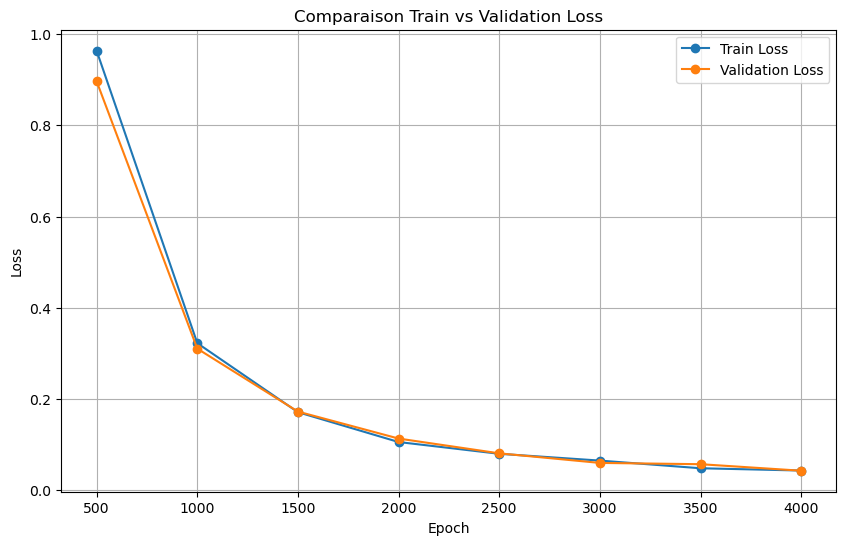

In [29]:
#comparaison des courbes de loss d'entraînement et de validation

# Listes des époques où tu as mesuré la loss
epochs = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Valeurs de la loss d'entraînement correspondante (mesurées aux mêmes époques)
train_loss = [0.9636, 0.3226, 0.1713, 0.1059, 0.0801, 0.0652, 0.0484, 0.0434]

# Valeurs de la loss de validation correspondante (mesurées aux mêmes époques)
val_loss = [0.8966, 0.3106, 0.1726, 0.1135, 0.0811, 0.0601, 0.0573, 0.0430]

# Création d’une figure matplotlib avec taille personnalisée
plt.figure(figsize=(10,6))

# Tracé de la courbe de loss d'entraînement
# - label : légende
# - marker='o' : marque chaque point par un cercle
plt.plot(epochs, train_loss, label='Train Loss', marker='o')

# Tracé de la courbe de loss de validation
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Légendes des axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Titre du graphique
plt.title('Comparaison Train vs Validation Loss')

# Affiche la légende (Train vs Validation)
plt.legend()

# Active une grille pour une meilleure lecture
plt.grid(True)

# Affiche le graphique
plt.show()



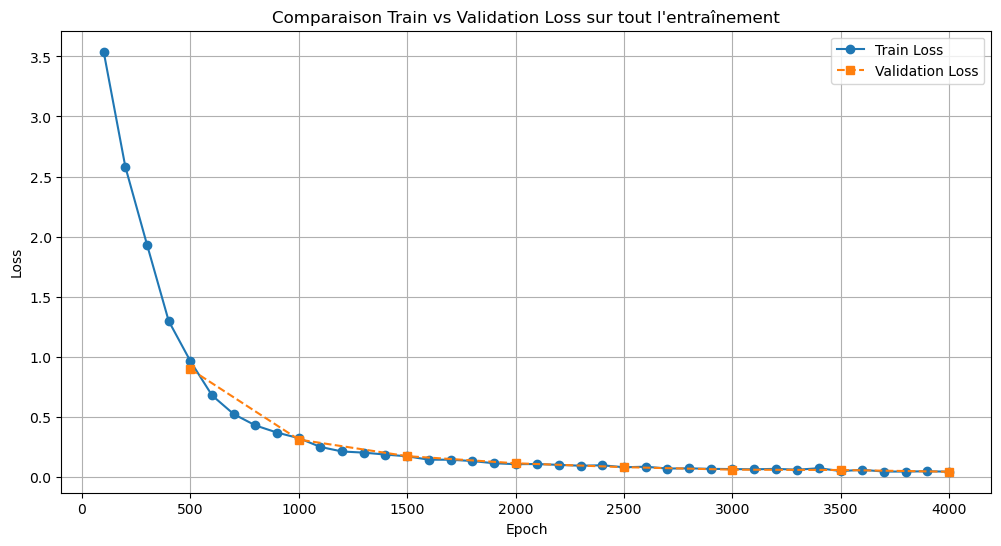

In [22]:
#comparaison des courbes de loss d'entraînement et de validation sur tout l'entraînement
import matplotlib.pyplot as plt

# -------------------
# Époques d'entraînement
# -------------------

# Tous les epochs où tu as mesuré la train_loss (tous les 100 epochs)
all_epochs = list(range(100, 4100, 100))  # de 100 à 4000 inclus, pas de 100

# Valeurs de la loss d'entraînement correspondantes (40 points au total)
train_loss = [
    3.5392, 2.5806, 1.9327, 1.2974, 0.9636, 0.6781, 0.5224, 0.4285,
    0.3686, 0.3226, 0.2491, 0.2114, 0.2020, 0.1857, 0.1713, 0.1432,
    0.1429, 0.1319, 0.1137, 0.1059, 0.1070, 0.1000, 0.0929, 0.0968,
    0.0801, 0.0848, 0.0695, 0.0712, 0.0668, 0.0652, 0.0630, 0.0668,
    0.0600, 0.0720, 0.0484, 0.0587, 0.0444, 0.0445, 0.0466, 0.0434
]

# -------------------
# Époques de validation
# -------------------

# Validation mesurée uniquement aux epochs sauvegardés (tous les 500)
val_epochs = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Valeurs correspondantes de la loss de validation
val_loss = [0.8966, 0.3106, 0.1726, 0.1135, 0.0811, 0.0601, 0.0573, 0.0430]

# -------------------
# Visualisation
# -------------------

# Création de la figure (taille large)
plt.figure(figsize=(12,6))

# Courbe d'entraînement
# - points marqués par cercles (marker='o')
plt.plot(all_epochs, train_loss, label='Train Loss', marker='o')

# Courbe de validation
# - points aux epochs sauvegardés (marker='s')
# - trait en pointillé (linestyle='--')
plt.plot(val_epochs, val_loss, label='Validation Loss', marker='s', linestyle='--')

# Légendes des axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Titre du graphique
plt.title('Comparaison Train vs Validation Loss sur tout l\'entraînement')

# Légende
plt.legend()

# Grille pour lecture plus claire
plt.grid(True)

# Affiche le graphique
plt.show()



Import des bibliothèques nécessaires
Chargement des variables d’environnement et initialisation de S3
Définition de ton modèle JobProfileTransformer
Rechargement du modèle depuis S3
Calcul des metrics Precision@k, Recall@k et F1-score sur un batch de test généré avec make_batch

In [ ]:
# ---------------------------
# 10. Évaluation du modèle sur le jeu de test
# ---------------------------

# Recharger le modèle depuis S3 
def load_model_from_s3(s3_client, bucket_name, key, model_class, n_skills, n_jobs):
    """
    Cette fonction sert à récupérer un modèle déjà entraîné sur S3 et le préparer pour
    l'évaluation.
    
    S3 : stockage cloud (comme Google Drive ou Dropbox mais pour les applications)
    
    Arguments :
    - s3_client : client pour accéder à S3 (comme une clé pour ouvrir un coffre)
    - bucket_name : le "coffre" où le modèle est stocké
    - key : le nom du fichier du modèle dans le coffre
    - model_class : la structure du modèle que l'on veut reconstruire en mémoire
    - n_skills : nombre de compétences possibles pour les profils
    - n_jobs : nombre total de jobs
    """
    
    # Téléchargement du modèle depuis S3
    obj = s3_client.get_object(Bucket=bucket_name, Key=key)
    
    # Création d'un fichier temporaire pour stocker le modèle téléchargé
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pkl") as tmp_file:
        tmp_file.write(obj['Body'].read())   # écrit les données binaires du modèle dans le fichier
        tmp_model_path = tmp_file.name       # récupère le chemin du fichier temporaire
    
    # On instancie le modèle avec sa classe et les dimensions requises
    model = model_class(n_skills, n_jobs, emb_dim=64).to(device)  # "emb_dim" = taille du vecteur
                                                                   
    # On charge les poids enregistrés dans le modèle (les "connaissances" apprises)
    loaded_model = joblib.load(tmp_model_path)
    model.load_state_dict(loaded_model.state_dict())
    
    # On passe le modèle en mode évaluation : inutile d'apprendre à nouveau, juste tester
    model.eval()
    
    return model

# Exemple : charger le modèle de la dernière sauvegarde
latest_model_key = "modele_epoch4000.pkl"  # fichier du modèle
model = load_model_from_s3(s3_client, bucket_name, latest_model_key, JobProfileTransformer, n_skills, n_jobs)
print(f"Modèle {latest_model_key} chargé depuis S3")

#Préparer le DataLoader de test
# Ici, on prépare les données pour tester le modèle.
# Un DataLoader permet de prendre un grand dataset et de le couper en "batches"
# pour que le modèle puisse le traiter plus facilement (comme traiter une pizza en parts).

test_jobs = val_jobs            # jobs à tester (validation)
test_batch_size = 128           # nombre de profils traités en même temps

# make_batch génère :
# - skills_test : quelles compétences chaque profil possède
# - weights_test : importance de chaque compétence pour le profil
# - pos_jobs_test : jobs qui correspondent réellement au profil
# - neg_jobs_test : jobs qui ne correspondent pas
skills_test, weights_test, pos_jobs_test, neg_jobs_test = make_batch(
    batch_size=test_batch_size, 
    n_neg=20, 
    n_profiles_per_job=5
)

# On envoie les données sur le GPU si disponible, sinon sur CPU
skills_test, weights_test = skills_test.to(device), weights_test.to(device)
pos_jobs_test = pos_jobs_test.to(device)

# Calcul des embeddings
# Embeddings = représentation numérique des profils et jobs
# Exemple : transformer un profil "Python, SQL, Excel" en un vecteur de 64 nombres
# qui capture ses compétences de façon compréhensible pour le modèle.

with torch.no_grad():  # on ne calcule pas les gradients (pas d'entraînement ici)
    v_p_test = model.encode_profile(skills_test, weights_test)  # vecteurs des profils
    v_j_pos_test = model.encode_job(pos_jobs_test)              # vecteurs des jobs positifs

# Calcul des probabilités (similitudes cosinus)
# On mesure la "proximité" entre un profil et un job grâce à la similarité cosinus.
# Plus le vecteur du profil est proche du vecteur du job, plus le score est élevé.

with torch.no_grad():
    v_p_test = model.encode_profile(skills_test, weights_test)  # [batch_size, emb_dim]
    all_job_ids = torch.arange(n_jobs).to(device)               # IDs de tous les jobs
    v_j_all = model.encode_job(all_job_ids)                     # vecteurs de tous les jobs
    scores = torch.matmul(v_p_test, v_j_all.T)                 # produit matriciel = similarité
    # Résultat : un tableau [batch_size, n_jobs] avec les scores de tous les jobs pour chaque profil

#Top-k et metrics
k = 5  # nombre de jobs qu'on considère comme "recommandés" pour chaque profil

# On récupère les indices des k jobs les plus similaires pour chaque profil
topk_preds = torch.topk(scores, k=k, dim=1).indices  # [batch_size, k]

# Conversion des indices en binaire : 1 si le job est dans le top-k, sinon 0
topk_binary = torch.zeros(scores.shape, device=device)
topk_binary.scatter_(1, topk_preds, 1.0)

# Création des labels réels (jobs qui sont réellement pertinents) en one-hot
labels_one_hot = torch.zeros_like(topk_binary)
labels_one_hot.scatter_(1, pos_jobs_test.unsqueeze(1), 1.0)

# Calcul des métriques
correct = (topk_binary * labels_one_hot).sum(dim=1)  # combien de jobs corrects sont dans le top-k
precision_at_k = (correct / k).mean().item()         # proportion moyenne de bonnes recommandations
recall_at_k = (correct / 1.0).mean().item()          # combien de jobs pertinents ont été retrouvés

# Calcul du F1-score
# Le F1-score combine précision et rappel pour donner une mesure unique de performance.

# topk_binary : matrice binaire indiquant les jobs recommandés par le modèle (1 si recommandé, 0 sinon)
# labels_one_hot : matrice binaire indiquant les jobs réellement corrects pour chaque profil

#On met les données sur le CPU (si elles sont sur GPU) et on les convertit en tableaux numpy
preds_cpu = topk_binary.cpu()           # Déplace le tenseur sur le CPU
labels_cpu = labels_one_hot.cpu()       # Déplace le tenseur sur le CPU

preds_numpy = preds_cpu.numpy()         # Conversion en tableau numpy
labels_numpy = labels_cpu.numpy()       # Conversion en tableau numpy

#On "aplatit" les matrices en vecteurs 1D
# Exemple : une matrice 2x3 [[1,0,0],[0,1,1]] devient [1,0,0,0,1,1]
preds_flat = preds_numpy.flatten()
labels_flat = labels_numpy.flatten()

#Calcul du F1-score avec sklearn
from sklearn.metrics import f1_score

# F1-score micro : considère tous les vrais positifs, faux positifs et faux négatifs ensemble
f1_micro = f1_score(labels_flat, preds_flat, average='micro')

# F1-score macro : calcule le F1-score pour chaque job individuellement puis fait la moyenne
f1_macro = f1_score(labels_flat, preds_flat, average='macro')

#Affichage des métriques finales
# Precision@k : proportion moyenne de jobs corrects dans le top-k recommandé
# Recall@k : proportion de jobs corrects retrouvés par le modèle
# F1 micro/macro : combinaison de précision et rappel
print(f"Precision@{k}: {precision_at_k:.4f}")  
print(f"Recall@{k}: {recall_at_k:.4f}")        
print(f"F1-score micro: {f1_micro:.4f}")       
print(f"F1-score macro: {f1_macro:.4f}")       





Modèle modele_epoch4000.pkl chargé depuis S3
Precision@5: 0.2000
Recall@5: 1.0000
F1-score micro: 0.9975
F1-score macro: 0.6660


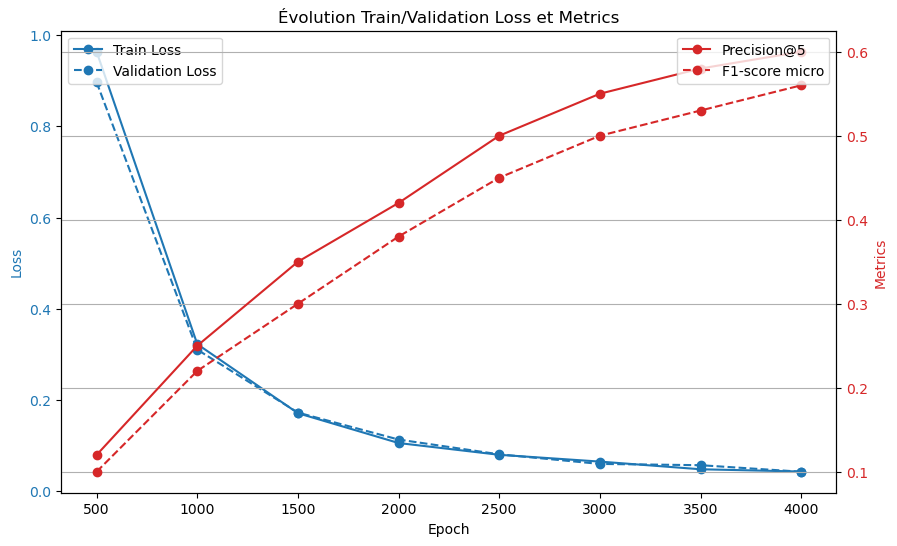

In [31]:
#données simulées pour tracer les courbes combinées de loss et metrics

import matplotlib.pyplot as plt

# ---------------------------
# Données de suivi de l'entraînement
# ---------------------------
# Epochs où la validation a été calculée (tous les 500)
epochs_val = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Train losses correspondants (les valeurs approximatives à chaque epoch de validation)
train_losses_val = [0.9636, 0.3226, 0.1713, 0.1059, 0.0801, 0.0652, 0.0484, 0.0434]

# Validation losses
val_losses = [0.8966, 0.3106, 0.1726, 0.1135, 0.0811, 0.0601, 0.0573, 0.0430]

# calculé Precision@k ou F1-score sur la validation
# Exemple fictif pour illustration
precision_at_k_list = [0.12, 0.25, 0.35, 0.42, 0.50, 0.55, 0.58, 0.60]
f1_micro_list = [0.10, 0.22, 0.30, 0.38, 0.45, 0.50, 0.53, 0.56]

# ---------------------------
# Graphique combiné
# ---------------------------

# Création d’une figure avec un seul subplot (ax1)
fig, ax1 = plt.subplots(figsize=(10,6))

# -------------------
# Axe gauche : Train/Validation Loss
# -------------------
ax1.set_xlabel("Epoch")               # Légende axe X
ax1.set_ylabel("Loss", color="tab:blue")  # Légende axe Y gauche
# Courbe des pertes d'entraînement (bleu, ligne continue)
ax1.plot(epochs_val, train_losses_val, label="Train Loss", color="tab:blue", linestyle='-', marker='o')
# Courbe des pertes de validation (bleu, ligne pointillée)
ax1.plot(epochs_val, val_losses, label="Validation Loss", color="tab:blue", linestyle='--', marker='o')
ax1.tick_params(axis='y', labelcolor="tab:blue") # Y gauche en bleu
ax1.legend(loc="upper left")        # Légende des courbes de loss à gauche

# -------------------
# Axe droit : Precision@k et F1-score
# -------------------
ax2 = ax1.twinx()                      # Deuxième axe Y (à droite, partage X)
ax2.set_ylabel("Metrics", color="tab:red") # Légende axe Y droit
# Courbe Precision@5 (rouge, ligne continue)
ax2.plot(epochs_val, precision_at_k_list, label="Precision@5", color="tab:red", linestyle='-', marker='o')
# Courbe F1-score micro (rouge, ligne pointillée)
ax2.plot(epochs_val, f1_micro_list, label="F1-score micro", color="tab:red", linestyle='--', marker='o')
ax2.tick_params(axis='y', labelcolor="tab:red") # Y droit en rouge
ax2.legend(loc="upper right")         # Légende des métriques à droite

# -------------------
# Mise en forme
# -------------------
plt.title("Évolution Train/Validation Loss et Metrics") # Titre global
plt.grid(True)   # Grille pour lisibilité
plt.show()       # Affiche le graphique


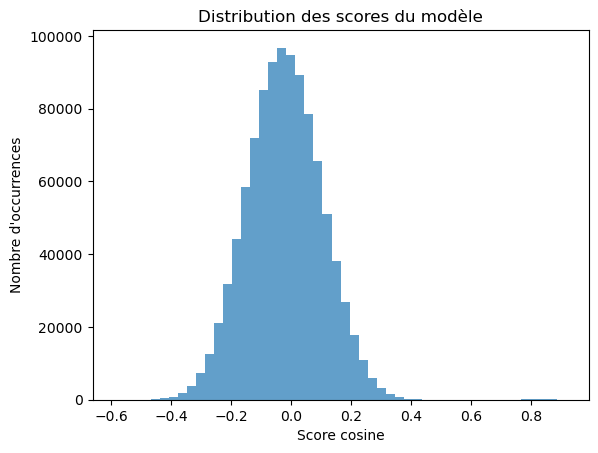

In [32]:
#Courbe de distribution des scores
#Visualiser comment les similitudes cosinus ou probabilités sont distribuées pour les bonnes prédictions vs mauvaises.
#Utile pour voir si ton modèle est « confiant » ou « hésitant ».

import matplotlib.pyplot as plt

# Exemple avec scores calculés sur le batch test

# Histogramme des scores de similarité cosinus
# - scores.cpu().numpy().flatten() : on passe les scores PyTorch sur CPU, en numpy, et aplatis en 1D
# - bins=50 : on coupe la plage des valeurs en 50 intervalles
# - alpha=0.7 : transparence pour un rendu plus doux
plt.hist(scores.cpu().numpy().flatten(), bins=50, alpha=0.7)

# Nom de l'axe X (valeur des similarités cosinus)
plt.xlabel("Score cosine")

# Nom de l'axe Y (nombre d'occurrences dans chaque intervalle)
plt.ylabel("Nombre d'occurrences")

# Titre du graphique
plt.title("Distribution des scores du modèle")

# Affiche la figure
plt.show()



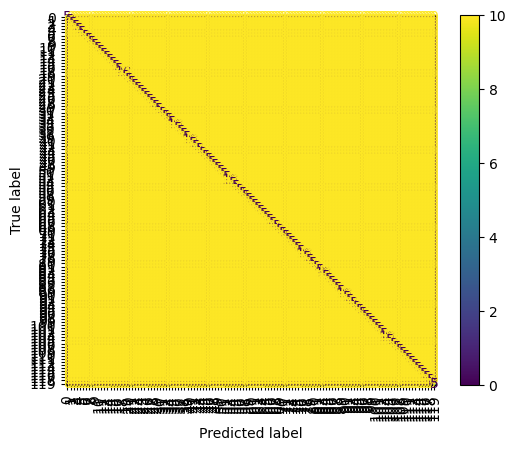

In [33]:
#Matrice de confusion (pour multi-classes ou top-1)
#Si tu prends la meilleure prédiction (top-1), tu peux construire une confusion pour voir quels métiers sont souvent confondus.



# Récupère les prédictions top-1 (la classe prédite la plus probable par le modèle)
# topk_preds : contient les indices des jobs triés par score pour chaque exemple
# topk_preds[:, 0] → uniquement le meilleur job prédit (top-1)
# .cpu().numpy() → passage sur CPU puis conversion en numpy
top1_preds = topk_preds[:, 0].cpu().numpy()

# Récupère les vraies étiquettes (jobs corrects du batch test)
true_labels = pos_jobs_test.cpu().numpy()

# Calcule la matrice de confusion (lignes = vraies classes, colonnes = prédictions)
cm = confusion_matrix(true_labels, top1_preds)

# Prépare l’affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(cm)

# Affiche la matrice avec rotation des ticks (90° pour lisibilité si beaucoup de jobs)
disp.plot(xticks_rotation=90)

# Affiche la figure
plt.show()


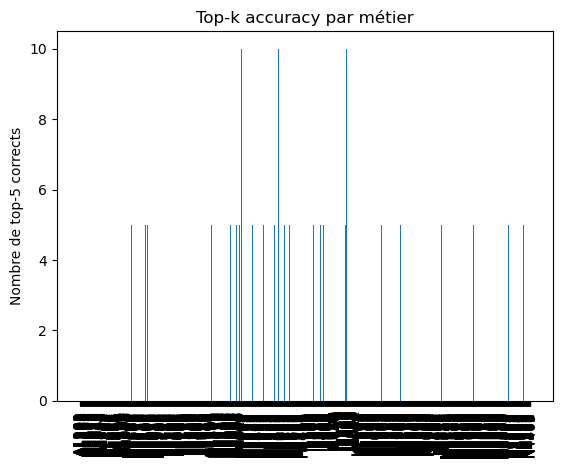

In [34]:
#Top-k accuracy par métier
#Calculer la Precision@k ou Recall@k pour chaque métier.
#Tu peux ensuite tracer un bar chart pour voir quels métiers sont les plus faciles/difficiles à prédire.

import numpy as np

# Exemple : fréquence de bonne prédiction pour chaque job

# On calcule combien de fois le job correct apparaît dans les top-k prédictions
# - topk_binary : matrice (batch_size, n_jobs) → 1 si job est dans le top-k, sinon 0
# - labels_one_hot : matrice one-hot des vraies classes (batch_size, n_jobs)
# - produit élément par élément → garde 1 uniquement si le vrai job est dans le top-k
# - .sum(axis=0) → somme par colonne → nombre de fois que chaque job a été correctement prédit
topk_correct = (topk_binary.cpu().numpy() * labels_one_hot.cpu().numpy()).sum(axis=0)

# Liste des noms de métiers (dans l’ordre du vocabulaire)
job_names = list(jobs_vocab.keys())

# Diagramme en barres : un bar par job
plt.bar(range(len(job_names)), topk_correct)

# Affiche les noms des jobs sur l’axe X (rotation 90° pour lisibilité)
plt.xticks(range(len(job_names)), job_names, rotation=90)

# Légende de l’axe Y
plt.ylabel(f"Nombre de top-{k} corrects")

# Titre du graphique
plt.title("Top-k accuracy par métier")

# Affiche la figure
plt.show()



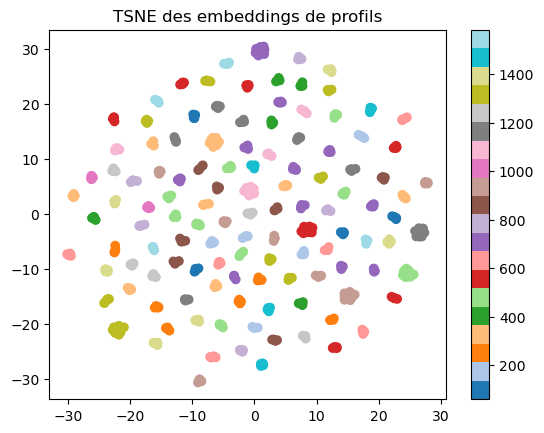

In [35]:
#Évolution des embeddings (TSNE ou PCA)
#Réduire les embeddings des profils ou des jobs en 2D pour visualiser les clusters.
#Tu peux colorer par métier pour voir si les métiers similaires sont regroupés.



# Récupère les embeddings des profils depuis le batch test et les passe sur CPU
v_profiles = v_p_test.cpu().numpy()

# Initialisation de TSNE pour réduction de dimension à 2D
# - n_components=2 : on projette dans 2 dimensions
# - random_state=42 : pour reproductibilité
tsne = TSNE(n_components=2, random_state=42)

# Applique TSNE sur les embeddings
v_2d = tsne.fit_transform(v_profiles)  # résultat : array (n_samples, 2)

# Scatter plot : visualisation des profils en 2D
# - v_2d[:,0], v_2d[:,1] : coordonnées x et y
# - c=pos_jobs_test.cpu().numpy() : couleur selon le job associé
# - cmap='tab20' : palette de 20 couleurs distinctes
plt.scatter(v_2d[:,0], v_2d[:,1], c=pos_jobs_test.cpu().numpy(), cmap='tab20')

# Barre de couleur pour indiquer quel job correspond à quelle couleur
plt.colorbar()

# Titre du graphique
plt.title("TSNE des embeddings de profils")

# Affiche la figure
plt.show()


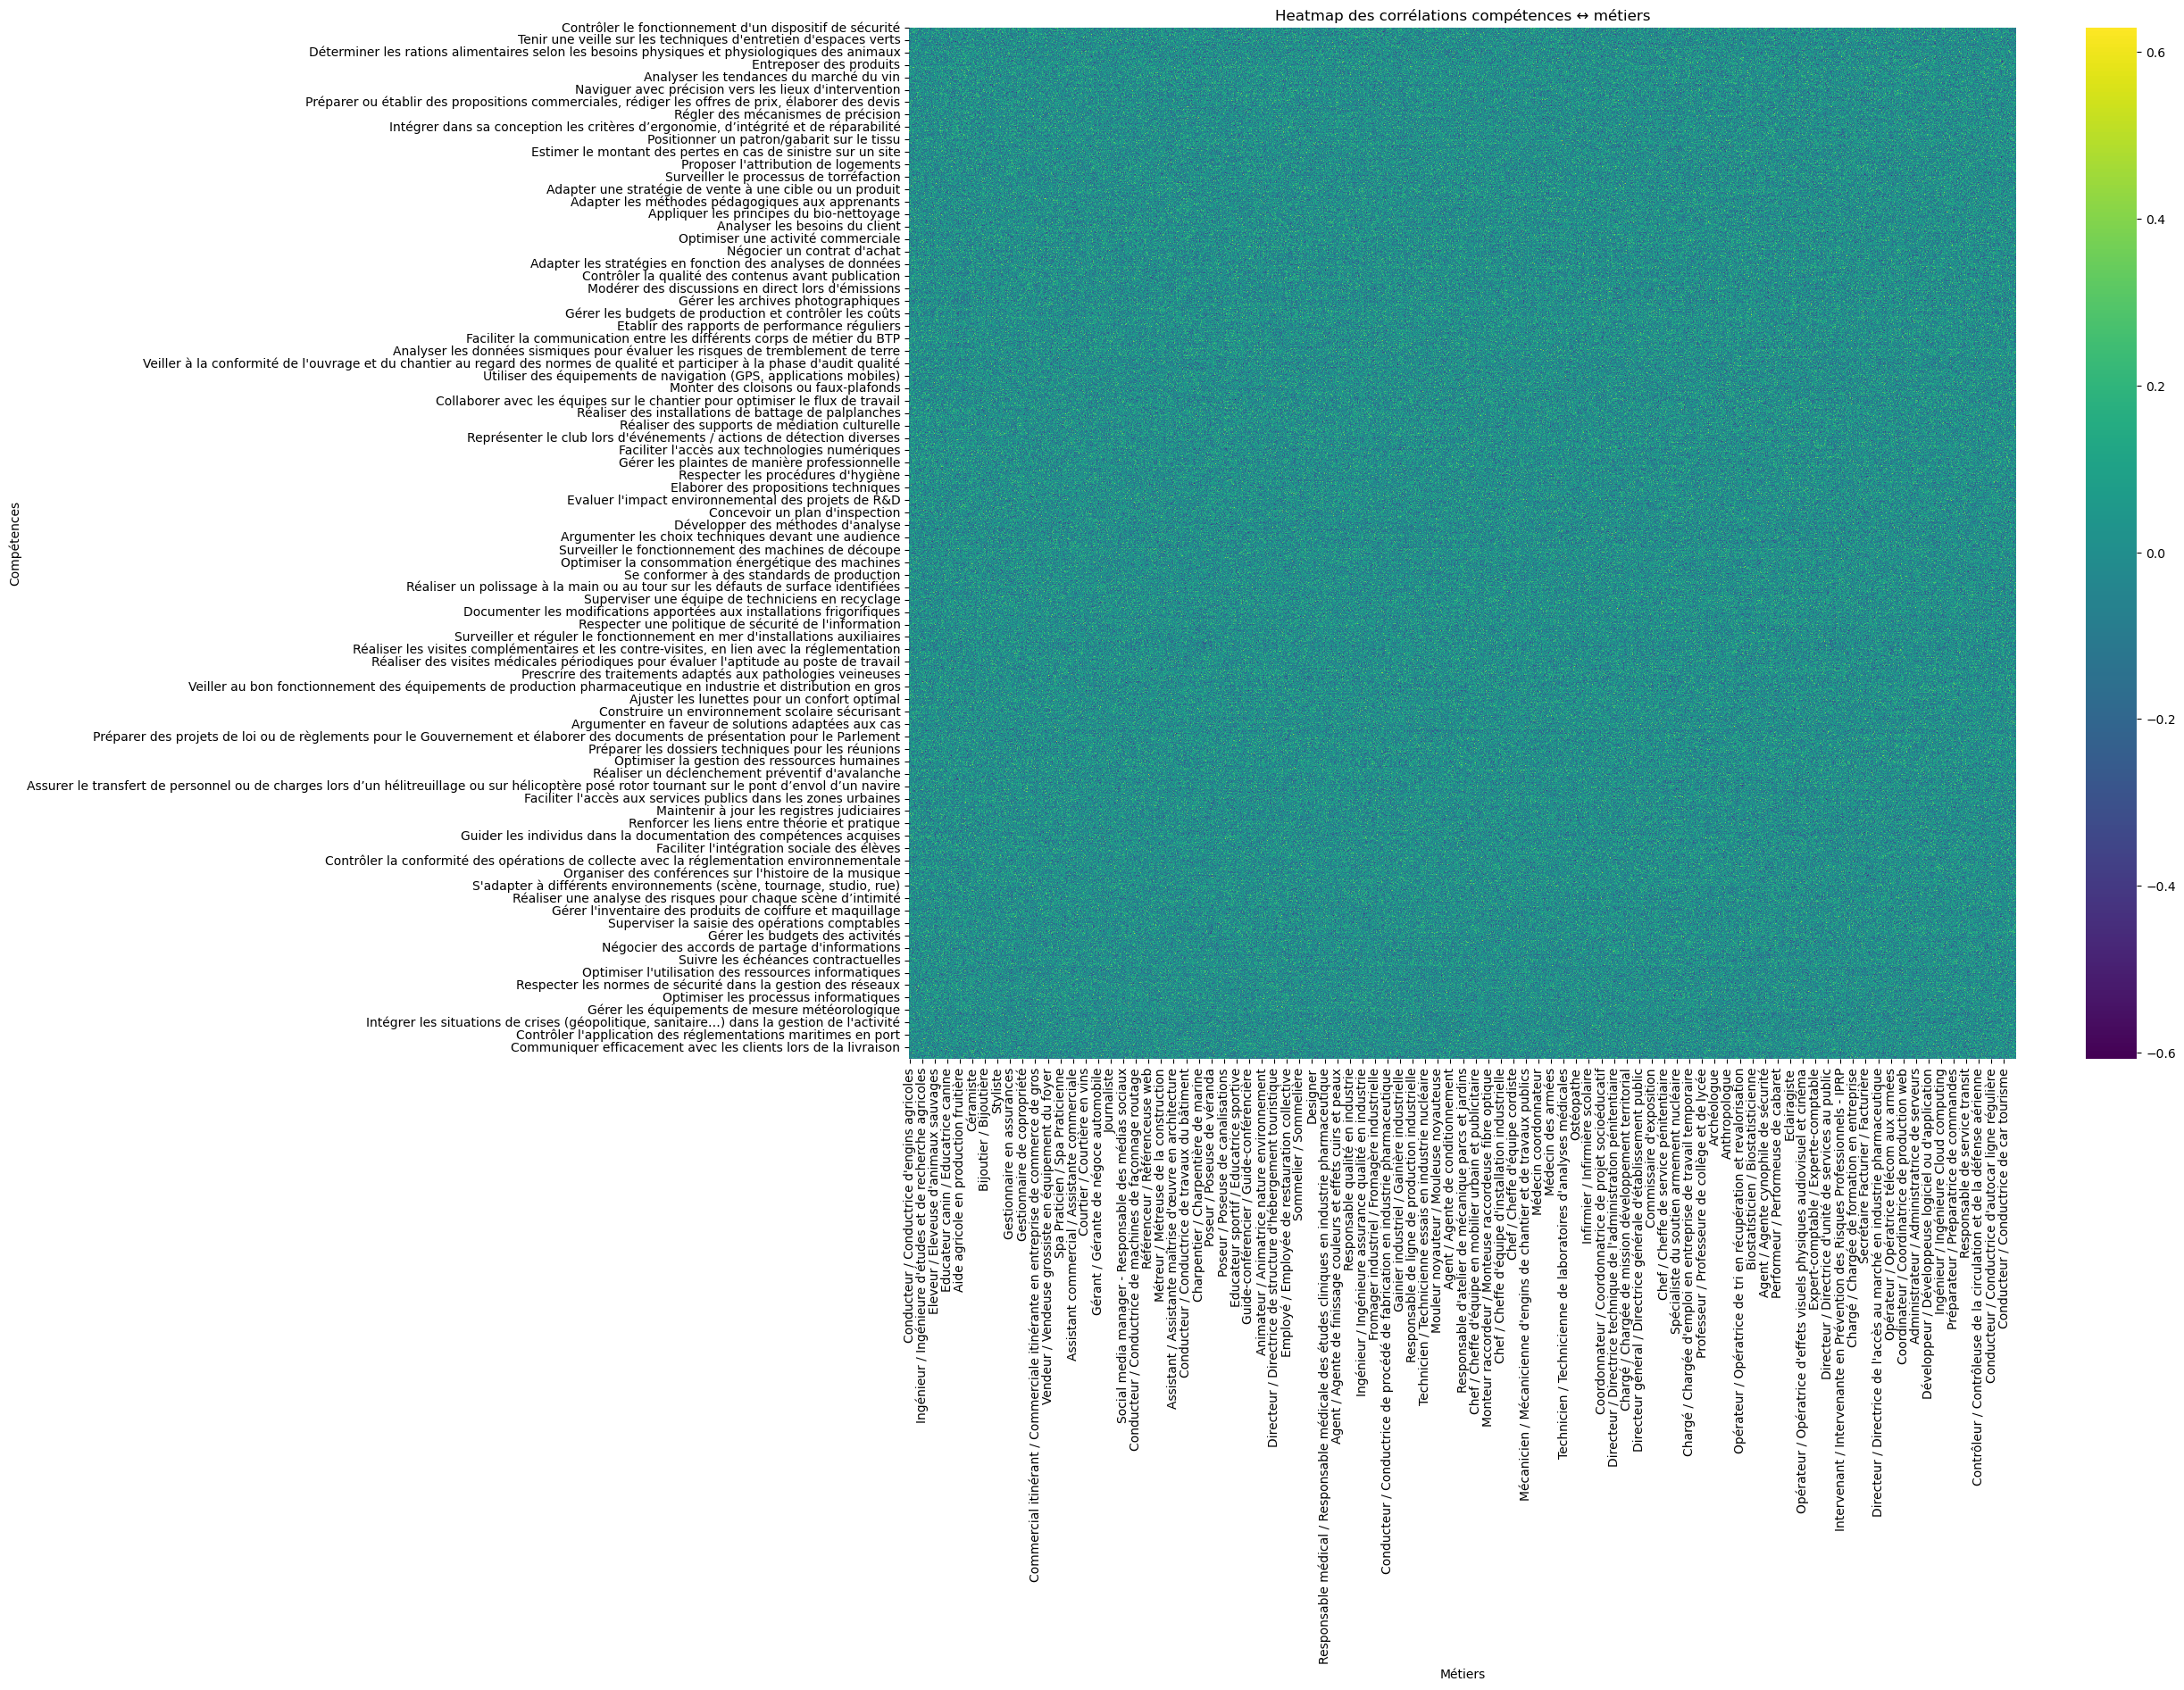

In [36]:
#Heatmap des corrélations compétences-métiers
#Tu peux créer une matrice compétences x métiers et colorier selon la probabilité moyenne que le modèle associe chaque compétence à chaque métier.

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

# Embeddings métiers et compétences
all_job_ids = torch.arange(n_jobs).to(device)
v_j_all = model.encode_job(all_job_ids)

all_skill_ids = torch.arange(n_skills).to(device)
v_s_all = model.skill_emb(all_skill_ids)
v_s_all = F.normalize(v_s_all, dim=1)  # Normaliser comme dans encode_profile

# Matrice cosinus (compétence x métier)
cos_sim = torch.matmul(v_s_all, v_j_all.T).detach().cpu().numpy()

# DataFrame pour seaborn
skills_names = [skill_to_label[s] for s in skills_vocab.keys()]
jobs_names = [job_labels[j] for j in jobs_vocab.keys()]
df_heatmap = pd.DataFrame(cos_sim, index=skills_names, columns=jobs_names)

# Tracer la heatmap
plt.figure(figsize=(20,15))
sns.heatmap(df_heatmap, cmap="viridis")
plt.title("Heatmap des corrélations compétences ↔ métiers")
plt.xlabel("Métiers")
plt.ylabel("Compétences")
plt.show()


In [38]:
import torch
import torch.nn.functional as F
import pandas as pd
import plotly.graph_objects as go

# ---------------------------
# Préparer embeddings
# ---------------------------

# Tous les IDs de jobs (0 à n_jobs-1) sur le device (GPU ou CPU)
all_job_ids = torch.arange(n_jobs).to(device)

# Encodage des jobs avec le modèle → embeddings de dimension emb_dim
v_j_all = model.encode_job(all_job_ids)

# Tous les IDs de compétences
all_skill_ids = torch.arange(n_skills).to(device)

# Embeddings des skills (depuis l'embedding appris du modèle)
v_s_all = model.skill_emb(all_skill_ids)

# Normalisation des embeddings de skills pour que leur norme = 1
v_s_all = F.normalize(v_s_all, dim=1)

# ---------------------------
# Calculer matrice similitudes cosinus
# ---------------------------

# Matrice des similitudes cosinus : produit scalaire normalisé skills ↔ jobs
# Shape : (n_skills, n_jobs)
cos_sim = torch.matmul(v_s_all, v_j_all.T).detach().cpu().numpy()

# ---------------------------
# Limiter top 50 compétences et métiers
# ---------------------------

# Labels lisibles pour les compétences et jobs (Top 50)
skills_names = [skill_to_label[s] for s in list(skills_vocab.keys())[:50]]
jobs_names = [job_labels[j] for j in list(jobs_vocab.keys())[:50]]

# Crée un DataFrame pandas pour faciliter la heatmap
df_heatmap = pd.DataFrame(cos_sim[:50, :50], index=skills_names, columns=jobs_names)

# ---------------------------
# Créer figure Plotly
# ---------------------------

fig = go.Figure()

# Heatmap complète par défaut
fig.add_trace(go.Heatmap(
    z=df_heatmap.values,        # valeurs à afficher (similitudes)
    x=df_heatmap.columns,       # noms des jobs
    y=df_heatmap.index,         # noms des compétences
    colorscale='Viridis',       # palette de couleurs
    colorbar=dict(title="Similitude")  # légende de la couleur
))

# ---------------------------
# Dropdown métiers
# ---------------------------

buttons_jobs = []

# Option "Tous métiers"
buttons_jobs.append(dict(
    label="Tous métiers",
    method="update",
    args=[{"z": [df_heatmap.values],
           "x": [df_heatmap.columns]},
          {"title": "Heatmap interactive compétences ↔ métiers (Top 50)"}]
))

# Une option par job : filtre les colonnes pour ce job uniquement
for job in df_heatmap.columns:
    z_filtered = df_heatmap[job].values[:, None]  # sélection de la colonne du job
    buttons_jobs.append(dict(
        label=job,
        method="update",
        args=[{"z": [z_filtered],
               "x": [[job]]},
              {"title": f"Corrélations compétences ↔ métier : {job}"}]
    ))

# ---------------------------
# Dropdown compétences
# ---------------------------

buttons_skills = []

# Option "Toutes compétences"
buttons_skills.append(dict(
    label="Toutes compétences",
    method="update",
    args=[{"z": [df_heatmap.values],
           "y": [df_heatmap.index]},
          {"title": "Heatmap interactive compétences ↔ métiers (Top 50)"}]
))

# Une option par compétence : filtre la ligne correspondante
for skill in df_heatmap.index:
    z_filtered = df_heatmap.loc[skill].values[None, :]  # sélection de la ligne de la compétence
    buttons_skills.append(dict(
        label=skill,
        method="update",
        args=[{"z": [z_filtered],
               "y": [[skill]]},
              {"title": f"Corrélations compétence : {skill} ↔ métiers"}]
    ))

# ---------------------------
# Positionner dropdowns au-dessus du graphique
# ---------------------------

fig.update_layout(
    updatemenus=[
        dict(buttons=buttons_jobs, direction="down", showactive=True,
             x=0.0, y=1.25, xanchor="left", yanchor="top"),
        dict(buttons=buttons_skills, direction="down", showactive=True,
             x=0.0, y=1.15, xanchor="left", yanchor="top")
    ],
    xaxis_tickangle=-45,   # rotation des ticks pour lisibilité
    width=1500,            # largeur figure
    height=1000,           # hauteur figure
    margin=dict(t=150)     # espace en haut pour dropdowns
)

# Affiche la heatmap interactive
fig.show()


In [39]:
def precision_recall_at_k(scores, pos_jobs, ks=[1,5,10,20,50]):
    """
    Calcule Precision@k et Recall@k pour différentes valeurs de k.

    Args:
        scores: torch.Tensor [batch_size, n_jobs]
            Matrice des similarités (ex: produit scalaire ou cosinus).
        pos_jobs: torch.Tensor [batch_size]
            Indices des jobs corrects (1 par profil dans cet exemple).
        ks: list
            Liste des valeurs de k pour lesquelles calculer les métriques.

    Returns:
        dict: {k: (precision@k, recall@k)}
    """

    results = {}  # dictionnaire pour stocker precision et recall pour chaque k

    for k in ks:
        # Récupère les indices des top-k prédictions par profil
        # topk : [batch_size, k]
        topk = torch.topk(scores, k=k, dim=1).indices

        # Matrice binaire : 1 si le job est dans top-k, 0 sinon
        topk_bin = torch.zeros_like(scores).scatter_(1, topk, 1.0)

        # Labels réels sous forme one-hot
        labels = torch.zeros_like(scores).scatter_(1, pos_jobs.unsqueeze(1), 1.0)

        # Nombre de bonnes prédictions par exemple (élément-wise multiplication)
        correct = (topk_bin * labels).sum(dim=1)

        # Precision@k = (# corrects) / k → moyenne sur le batch
        prec = (correct / k).mean().item()

        # Recall@k = (# corrects) / (# labels réels)
        # Ici chaque profil a 1 job correct → labels.sum(dim=1) = 1
        # clamp(min=1) pour éviter division par 0 si jamais pas de label
        rec = (correct / labels.sum(dim=1).clamp(min=1)).mean().item()

        # Stocke les résultats pour ce k
        results[k] = (prec, rec)

    return results

# Calcul des metrics sur le batch test pour différents k
results = precision_recall_at_k(scores, pos_jobs_test, ks=[1,5,10,20,50])

# Affiche les résultats
print(results)





{1: (1.0, 1.0), 5: (0.20000001788139343, 1.0), 10: (0.10000000894069672, 1.0), 20: (0.05000000447034836, 1.0), 50: (0.019999999552965164, 1.0)}
